# Onboarding profit analysis
preprocess for the previous application data: 
1. delete the ones that have XNA or consumer loan type of loan
2. figuring out which have defaulted based on installment data
3. calculate the default loss (some customers does have payback before default)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
previous_application = pd.read_csv('./src/previous_application.csv')
application = pd.read_csv('./src/application_train.csv')

In [4]:
previous_application['NAME_CONTRACT_TYPE'].value_counts()  # we drop xna and change consumer loan to cash loan

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

In [5]:
application[
    'NAME_CONTRACT_TYPE'].value_counts()  # the application we care about only contains cash loan and revolving loan

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [6]:
previous_application = previous_application[
    previous_application['NAME_CONTRACT_TYPE'].isin(['Cash loans', 'Revolving loans'])]

In [7]:
# get previd for cash and revolving loan seperately
cash_loan_prev_id = previous_application[(previous_application['NAME_CONTRACT_TYPE'] == 'Cash loans')&(previous_application['NAME_CONTRACT_STATUS']=='Approved')][
    'SK_ID_PREV'].unique()
revolving_loan_prev_id = previous_application[(previous_application['NAME_CONTRACT_TYPE'] == 'Revolving loans')&(previous_application['NAME_CONTRACT_STATUS']=='Approved')][
    'SK_ID_PREV'].unique()

## 1. Process installment data

In [8]:
installments_payments = pd.read_csv('./src/installments_payments.csv')
installments_payments = installments_payments.groupby(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']).agg(
    {'DAYS_INSTALMENT': 'first', 'DAYS_ENTRY_PAYMENT': 'last', 'AMT_INSTALMENT': 'first',
     'AMT_PAYMENT': 'sum'}).reset_index()  # aggregate multiple payments for the same installment
installments_payments['AMOUNT_NOT_PAID'] = (
        installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']).apply(lambda
                                                                                                  x: 0 if x < 1 else x)  # only when insurancce is at play, the amount paid can be larger than the amount due. less than 1 because float precision
installments_payments['DAYS_DIFF'] = (
        installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']).apply(
    lambda x: 0 if x < 0 else x)  # there is no benefit for early repayment so we set it to 0

## 2. Seperate cash and revolving loan

In [9]:
cash_installment = installments_payments[installments_payments['SK_ID_PREV'].isin(cash_loan_prev_id)].copy()
revolving_loan_installment = installments_payments[
    installments_payments['SK_ID_PREV'].isin(revolving_loan_prev_id)].copy()

In [10]:
cash_installment[cash_installment['AMT_PAYMENT'] == 0]

,SK_ID_PREV,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMOUNT_NOT_PAID,DAYS_DIFF
122930,1010608,29,-3.0,NaN,26327.970,0.0,26327.970,NaN
159151,1016839,29,-76.0,NaN,45686.655,0.0,45686.655,NaN
159152,1016839,30,-46.0,NaN,45686.655,0.0,45686.655,NaN
159153,1016839,31,-16.0,NaN,45686.655,0.0,45686.655,NaN
248002,1030134,19,-5.0,NaN,4282.020,0.0,4282.020,NaN
...,...,...,...,...,...,...,...,...
12828162,2837223,101,-13.0,NaN,116.550,0.0,116.550,NaN
12852630,2842600,1,-87.0,NaN,20538.765,0.0,20538.765,NaN
12852631,2842600,2,-57.0,NaN,20538.765,0.0,20538.765,NaN
12852632,2842600,3,-27.0,NaN,20538.765,0.0,20538.765,NaN


## 3. Cash loan

In [11]:
cash_installment['DAYS_DIFF'] = cash_installment.apply(
    lambda x: x['DAYS_DIFF'] if x['AMOUNT_NOT_PAID'] < 1 else min(abs(x['DAYS_INSTALMENT']), abs(previous_application[previous_application['SK_ID_PREV'] == x['SK_ID_PREV']]['DAYS_TERMINATION'].values[0])), axis=1)  # if not payed in full, we count as delayed payment until now.


def cal_amount_delayed_payment(x):
    if x['DAYS_DIFF'] > 0:
        if x['AMOUNT_NOT_PAID'] < 1:
            return x['AMT_INSTALMENT']  # client paid in full but delayed
    return 0  # 2 possible situation: 1. day diff>0 and amount not paid>0.1, accounted by the amount not paid. 2. day diff<=0, no delayed payment


cash_installment['AMOUNT_DELAYED_PAYMENT'] = cash_installment.apply(cal_amount_delayed_payment, axis=1)

In [12]:
# assume 1% annual interest rate since the data is many years ago
annual_interest_rate = 0.01
# convert to monthly interest rate
monthly_interest_rate = (1 + annual_interest_rate) ** (1 / 12) - 1
# convert to daily interest rate
daily_interest_rate = (1 + annual_interest_rate) ** (1 / 365) - 1
daily_interest_rate

2.7261552008939205e-05

In [13]:
cash_installment

,SK_ID_PREV,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMOUNT_NOT_PAID,DAYS_DIFF,AMOUNT_DELAYED_PAYMENT
46,1000010,1,-558.0,-568.0,74682.00,74682.00,0.0,0.0,0.0
47,1000010,2,-528.0,-528.0,74682.00,74682.00,0.0,0.0,0.0
48,1000010,3,-498.0,-502.0,74682.00,74682.00,0.0,0.0,0.0
49,1000010,4,-468.0,-471.0,74682.00,74682.00,0.0,0.0,0.0
50,1000010,5,-438.0,-457.0,74682.00,74682.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
12861989,2843499,6,-1053.0,-1074.0,16074.00,16074.00,0.0,0.0,0.0
12861990,2843499,7,-1023.0,-1047.0,16074.00,16074.00,0.0,0.0,0.0
12861991,2843499,8,-993.0,-1018.0,16074.00,16074.00,0.0,0.0,0.0
12861992,2843499,9,-963.0,-980.0,16074.00,16074.00,0.0,0.0,0.0


In [14]:
def cal_past_loss(x):
    discount = (1+monthly_interest_rate)**abs(x['NUM_INSTALMENT_NUMBER'])
    loss_not_paid = (x['AMOUNT_NOT_PAID'] * (1 + daily_interest_rate) ** x['DAYS_DIFF'])/discount
    loss_delayed_payment = (x['AMOUNT_DELAYED_PAYMENT'] * (1 + daily_interest_rate) ** x['DAYS_DIFF'] - x[
        'AMOUNT_DELAYED_PAYMENT'])/discount
    loss_delayed_payment = loss_delayed_payment.sum()
    loss_not_paid = loss_not_paid.sum()
    return -(loss_not_paid + loss_delayed_payment)


def flag_default(x):
    if len(x[(x['AMOUNT_NOT_PAID'] > 1)&(x['DAYS_DIFF']>15)]) > 0:# float precision and grace period
        return 1
    return 0


def flag_delayed(x):
    if x['DAYS_DIFF'].any() > 15 and not flag_default(x):  # avg grace period is 15 days, avoid double counting
        return 1
    return 0

In [15]:
aggregated_cash_installment = pd.DataFrame()
aggregated_cash_installment['PAST_LOSS_NPV'] = cash_installment.groupby('SK_ID_PREV').apply(cal_past_loss)  # pass loss net present value
aggregated_cash_installment['DELAYED_FLAG'] = cash_installment.groupby('SK_ID_PREV').apply(flag_delayed)
aggregated_cash_installment['DEFAULT_FLAG'] = cash_installment.groupby('SK_ID_PREV').apply(flag_default)

In [16]:
aggregated_cash_installment

,PAST_LOSS_NPV,DELAYED_FLAG,DEFAULT_FLAG
SK_ID_PREV,,,
1000010,-0.000000,0,0
1000011,-5.006539,0,0
1000027,-0.000000,0,0
1000040,-0.000000,0,0
1000050,-0.000000,0,0
...,...,...,...
2843494,-0.000000,0,0
2843495,-0.638991,0,0
2843497,-0.000000,0,0


In [17]:
def cal_cash_future_loss_default(x):
    if not x['DEFAULT_FLAG']:
        return 0
    # get the slice in cash_installment
    slice = cash_installment[cash_installment['SK_ID_PREV'] == x.name]
    # get the last installment
    last_installment = slice['NUM_INSTALMENT_NUMBER'][
        slice['NUM_INSTALMENT_NUMBER'] < 100].max()  # penalty have installment number >100
    # try:
    #     contract_full_installment = previous_application[previous_application['SK_ID_PREV'] == x.name]['CNT_PAYMENT'].values[0]
    #     contract_annuity = previous_application[previous_application['SK_ID_PREV'] == x.name]['AMT_ANNUITY'].values[0]
    # except IndexError:
    #     print(x.name)
    #     return 0
    contract_full_installment = previous_application[previous_application['SK_ID_PREV'] == x.name]['CNT_PAYMENT'].values[0]
    contract_annuity = previous_application[previous_application['SK_ID_PREV'] == x.name]['AMT_ANNUITY'].values[0]
    if last_installment == contract_full_installment:
        # no more future installment
        return 0
    else:
        numerator = 1 - (1 + monthly_interest_rate) ** (-contract_full_installment + last_installment)
        return -(contract_annuity * numerator / monthly_interest_rate)/(1+monthly_interest_rate)**last_installment


def cal_cash_future_loss_delayed(x):
    if not x['DELAYED_FLAG']:
        return 0
    # get the slice in cash_installment
    slice = cash_installment[cash_installment['SK_ID_PREV'] == x.name]
    # get the last installment
    last_installment = slice['NUM_INSTALMENT_NUMBER'][
        slice['NUM_INSTALMENT_NUMBER'] < 100].max()  # penalty have installment number >100
    contract_full_installment = \
    previous_application[previous_application['SK_ID_PREV'] == x.name]['CNT_PAYMENT'].values[0]
    contract_annuity = previous_application[previous_application['SK_ID_PREV'] == x.name]['AMT_ANNUITY'].values[0]
    if last_installment == contract_full_installment:
        # no more future installment
        return 0
    else:
        avg_delayed_days = slice['DAYS_DIFF'][
                           -len(slice) // 2:].mean()  # only consider the last half of the installment avg delay
        future_loss_every_installment = contract_annuity * (
                    1 + daily_interest_rate) ** avg_delayed_days - contract_annuity
        numerator = 1 - (1 + monthly_interest_rate) ** (-contract_full_installment + last_installment)
        return -(future_loss_every_installment * numerator / monthly_interest_rate)/(1+monthly_interest_rate)**last_installment


aggregated_cash_installment['FUTURE_LOSS_DEFAULT'] = aggregated_cash_installment.apply(cal_cash_future_loss_default, axis=1)
aggregated_cash_installment['FUTURE_LOSS_DELAYED'] = aggregated_cash_installment.apply(cal_cash_future_loss_delayed, axis=1)

In [18]:
aggregated_cash_installment

,PAST_LOSS_NPV,DELAYED_FLAG,DEFAULT_FLAG,FUTURE_LOSS_DEFAULT,FUTURE_LOSS_DELAYED
SK_ID_PREV,,,,,
1000010,-0.000000,0,0,0.0,0
1000011,-5.006539,0,0,0.0,0
1000027,-0.000000,0,0,0.0,0
1000040,-0.000000,0,0,0.0,0
1000050,-0.000000,0,0,0.0,0
...,...,...,...,...,...
2843494,-0.000000,0,0,0.0,0
2843495,-0.638991,0,0,0.0,0
2843497,-0.000000,0,0,0.0,0


In [19]:
def cal_loan_pv(x):
    numerator = 1 - (1 + monthly_interest_rate) ** (-x['CNT_PAYMENT'])
    return x['AMT_ANNUITY'] * numerator / monthly_interest_rate-x['AMT_CREDIT']
aggregated_cash_installment['LOAN_PV'] = previous_application[previous_application['SK_ID_PREV'].isin(aggregated_cash_installment.index)].set_index('SK_ID_PREV').apply(cal_loan_pv, axis=1)
aggregated_cash_installment['LOAN_PROFIT']=aggregated_cash_installment['PAST_LOSS_NPV']+aggregated_cash_installment['FUTURE_LOSS_DEFAULT']+aggregated_cash_installment['FUTURE_LOSS_DELAYED']+aggregated_cash_installment['LOAN_PV']

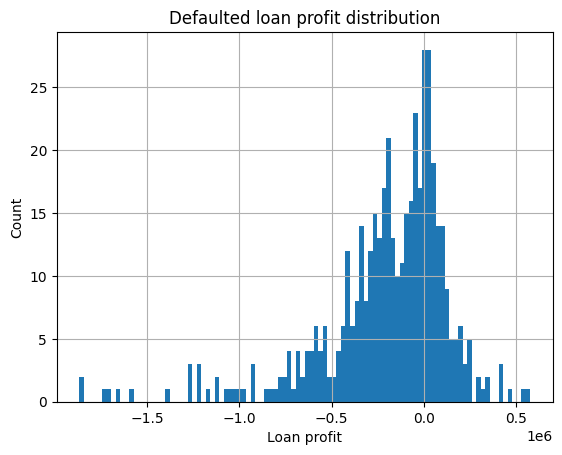

In [20]:
aggregated_cash_installment[aggregated_cash_installment['DEFAULT_FLAG']==1]['LOAN_PROFIT'].hist(bins=100)
plt.title('Defaulted loan profit distribution')
plt.xlabel('Loan profit')
plt.ylabel('Count')
plt.show()

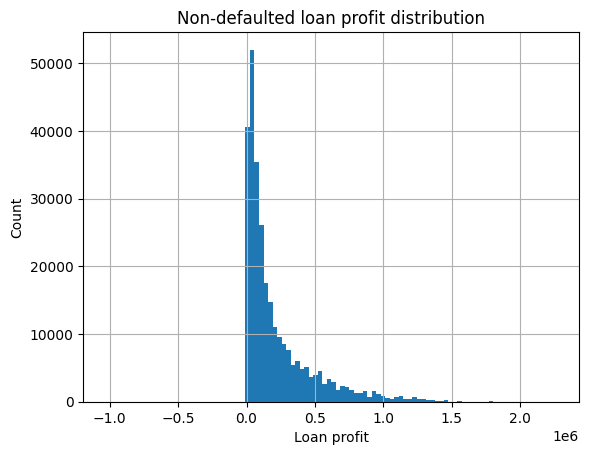

In [21]:
aggregated_cash_installment[aggregated_cash_installment['DEFAULT_FLAG']==0]['LOAN_PROFIT'].hist(bins=100)
plt.title('Non-defaulted loan profit distribution')
plt.xlabel('Loan profit')
plt.ylabel('Count')
plt.show()

## 4. Revolving loan

In [22]:
revolving_loan_installment['DAYS_DIFF'] = revolving_loan_installment.apply(
    lambda x: x['DAYS_DIFF'] if x['AMOUNT_NOT_PAID'] < 1 else min(abs(x['DAYS_INSTALMENT']), abs(previous_application[previous_application['SK_ID_PREV'] == x['SK_ID_PREV']]['DAYS_TERMINATION'].values[0])), axis=1)  

In [23]:
revolving_loan_installment['AMOUNT_DELAYED_PAYMENT'] = revolving_loan_installment.apply(cal_amount_delayed_payment, axis=1)

In [24]:
revolving_loan_installment[revolving_loan_installment['AMOUNT_DELAYED_PAYMENT']>0]

,SK_ID_PREV,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMOUNT_NOT_PAID,DAYS_DIFF,AMOUNT_DELAYED_PAYMENT
715,1000087,3,-882.0,-880.0,6319.665,6319.665,0.0,2.0,6319.665
723,1000087,11,-760.0,-759.0,6938.550,6938.550,0.0,1.0,6938.550
725,1000087,13,-729.0,-727.0,6836.085,6836.085,0.0,2.0,6836.085
727,1000087,15,-699.0,-697.0,6713.595,6713.595,0.0,2.0,6713.595
2336,1000257,1,-422.0,-411.0,2395.800,2395.800,0.0,11.0,2395.800
...,...,...,...,...,...,...,...,...,...
12861224,2843461,3,-2156.0,-2155.0,4500.000,4500.000,0.0,1.0,4500.000
12861269,2843461,48,-1245.0,-1242.0,4500.000,4500.000,0.0,3.0,4500.000
12861894,2843493,8,-321.0,-319.0,3496.230,3496.230,0.0,2.0,3496.230
12861904,2843493,18,-168.0,-167.0,2996.010,2996.010,0.0,1.0,2996.010


In [25]:
aggregated_revolving_loan_installment = pd.DataFrame()

aggregated_revolving_loan_installment['DELAYED_FLAG'] = revolving_loan_installment.groupby('SK_ID_PREV').apply(flag_delayed)
aggregated_revolving_loan_installment['DEFAULT_FLAG'] = revolving_loan_installment.groupby('SK_ID_PREV').apply(flag_default)

In [26]:
def cal_revolving_future_loss_delayed(x):
    if not x['DELAYED_FLAG']:
        return 0
    # get the slice in cash_installment
    x_slice = revolving_loan_installment[revolving_loan_installment['SK_ID_PREV'] == x.name]
    # get the last installment
    avg_delayed_days = x_slice['DAYS_DIFF'][
                       -len(x_slice) // 2:].mean()  # only consider the last half of the installment avg delay
    avg_delayed_amount = x_slice['AMOUNT_DELAYED_PAYMENT'][
                       -len(x_slice) // 2:].mean()
    future_loss_every_installment = avg_delayed_amount * (
                1 + daily_interest_rate) ** avg_delayed_days - avg_delayed_amount
    # calculate in a perpetuity way 
    future_loss_every_installment/=monthly_interest_rate
    # discount back to day 1
    future_loss_every_installment/=(1+monthly_interest_rate)**x_slice['NUM_INSTALMENT_NUMBER'].max()
    return -future_loss_every_installment

def cal_revolving_past_loss_default(x):
    if not x['DEFAULT_FLAG']:
        return 0
    x_slice =  revolving_loan_installment[revolving_loan_installment['SK_ID_PREV'] == x.name]
    # discount back to npv
    delayed_npv = x_slice['AMOUNT_DELAYED_PAYMENT']*(1+daily_interest_rate)**x_slice['DAYS_DIFF']-x_slice['AMOUNT_DELAYED_PAYMENT']
    default_npv=x_slice['AMOUNT_NOT_PAID']/(1+monthly_interest_rate)**x_slice['NUM_INSTALMENT_NUMBER']
    return -(delayed_npv.sum()+default_npv.sum())
    
def cal_revolving_npv_profit(x):
    # https://www.wallstreetprep.com/knowledge/corporate-banking-101-revolving-credit-facilities/
    x_slice = x[x['AMOUNT_NOT_PAID']<1]
    total_credit=previous_application[previous_application['SK_ID_PREV']==x.name]['AMT_ANNUITY']
    upfront_fee = total_credit*0.001*(len(x_slice)//12)# 10 base point per annual 
    commitment_cal = x_slice.loc[:,['NUM_INSTALMENT_NUMBER','AMT_INSTALMENT']].copy()
    commitment_cal['ratio']=1-commitment_cal['AMT_INSTALMENT']/total_credit
    commitment_cal = commitment_cal[commitment_cal['ratio']]>0.2
    commitment_fee = commitment_cal['AMT_INSTALMENT']*commitment_cal['ratio']*0.001 /(1+monthly_interest_rate)**commitment_cal['NUM_INSTALMENT_NUMBER']# 10 base point 
    return commitment_fee.sum()+upfront_fee
aggregated_revolving_loan_installment['FUTURE_LOSS_DELAYED']=revolving_loan_installment.groupby('SK_ID_PREV').apply(cal_revolving_future_loss_delayed)
aggregated_revolving_loan_installment['PAST_LOSS_NPV'] = revolving_loan_installment.groupby('SK_ID_PREV').apply(cal_revolving_past_loss_default)  # pass loss net present value
aggregated_revolving_loan_installment['PAST_PROFIT_NPV']=revolving_loan_installment.groupby('SK_ID_PREV').apply(cal_revolving_npv_profit)

KeyError: 'DELAYED_FLAG'

In [ ]:
aggregated_revolving_loan_installment['LOAN_PROFIT']=aggregated_revolving_loan_installment['PAST_PROFIT_NPV']+aggregated_revolving_loan_installment['PAST_LOSS_NPV']+aggregated_revolving_loan_installment['FUTURE_LOSS_DELAYED']

In [ ]:
aggregated_revolving_loan_installment[aggregated_revolving_loan_installment['DEFAULT_FLAG']==1]['LOAN_PROFIT'].hist()

In [ ]:
aggregated_revolving_loan_installment[aggregated_revolving_loan_installment['DEFAULT_FLAG']==0]['LOAN_PROFIT'].hist()